3. Take selfies and do key point detection using above code. Describe the results you see. You should try multiple angles. (5 pts)

In [25]:
import numpy as np
from scipy.ndimage import gaussian_filter
import time
import matplotlib.pyplot as plt

# I have refered to the opencv github repository while working on my implementation: https://github.com/opencv/opencv/blob/4.x/modules/features2d/src/sift.dispatch.cpp#L309

class SIFT_Keypoint_Detector:
    def __init__(self, nfeatures=0, nLayersinOctave=5, contrastThreshold=0.01, 
                 edgeThreshold=10, sigma=1.6):
        # not required for our implementation, but kept for reference
        self.nfeatures = nfeatures
        # number of progressive blurring of an image done in each octave (the number of octaves is calculated from the input image - dimensions halved after each octave)
        self.nLayersinOctave = nLayersinOctave
        # threshold for the contrast check in the scale space maxima detection
        self.contrastThreshold = contrastThreshold
        # threshold for the edge response check in the scale space maxima detection
        self.edgeThreshold = edgeThreshold
        # initial sigma for the first image in the image pyramid
        self.sigma = sigma
        # scaling factor for the floating point arithmetic, used as power of 2 if want to convert the floating point arithmetic to integer arithmetic
        self.SIFT_FIXPT_SCALE = 1

    def create_initial_image(self, img, double_image_size=False):
        if len(img.shape) == 3:
            gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
        else:
            gray = img
        # Im using SIFT_FIXPT_SCALE = 1, so I'm keeping arithmetic in floating point and not scaling the floating point intensities to integers
        gray_float = gray.astype(np.float32) * self.SIFT_FIXPT_SCALE
        # we want the resulting image to have a blur by factor self.sigma. Assuming it is already blurred by factor of 1.6, we calculate the additional blur sigma using (required_blur^2 - (2*current_blur)^2)
        sig_diff = np.sqrt(max(self.sigma**2 - (1.6**2 * 4), 0.01))
        
        if double_image_size:
            # I double the image size here by repeating each pixel twice in both dimensions (inner loop is for columns and outer loop is for rows)
            gray_float = np.repeat(np.repeat(gray_float, 2, axis=0), 2, axis=1)
        # apply the additional blur to the image and return the initial image
        return gaussian_filter(gray_float, sig_diff)

    # build the Gaussian pyramid
    def build_Gaussian_Pyramid(self, base, nOctaves):
        # pre-compute the sigma values requried for progressive blurring in each octave
        # the k value is here is defined in the opencv implementation and is used as the scaling factor for the progressive blurring
        k = 2**(1. / self.nLayersinOctave)
        # store sigma values for each layer in the octave (nLayersinOctave + 3 as we need nLayersinOctave + 2 DoG so that every image can be compared with one sigma above and below and +1, so need nLayersinOctave + 3 images in each octave to get these nLayersinOctave + 2 DoG images for each octave)
        sigma = np.array([k**i * self.sigma for i in range(self.nLayersinOctave + 3)])
        # calculate the effective sigma for gaussian blurring in each layer of an octave
        sigma_diff = np.sqrt(np.diff(sigma**2))

        # build the gaussian pyramid
        pyramid = []
        # over each octave
        for o in range(nOctaves):
            # create an octave array to store the layers of the octave
            # initialised with the base image for the first octave
            # otherwise initialised with the downsampled image from the last image previous octave ([::2, ::2] does the downsampling). [-3] is used instead of [-1] from the previous octave to retain detail to an extent so that a lot of detail from the original image is not lost when building the DoG pyramid
            octave = [base] if o == 0 else [pyramid[-1][-3][::2, ::2]]
            # apply progressive for each layer in an octave
            for i in range(1, self.nLayersinOctave + 3):
                # append the blurred layer to the octave array
                octave.append(gaussian_filter(octave[-1], sigma_diff[i-1]))
            # append octave to the Gaussian pyramid
            pyramid.append(octave)
            # base = octave[-3][::2, ::2]
        return pyramid

    # build the Difference of Gaussian pyramid
    def build_DoG_Pyramid(self, Gaussian_Pyramid, nOctaves):
        # using list comprehension here as appending is faster with it than normal for loops.
        # access each octave from the Gaussian pyramid and for each octave build the DoG pyramid by taking the difference of consecutive layers in the octave
        return [[octave[i+1] - octave[i] for i in range(len(octave) - 1)]
                for octave in Gaussian_Pyramid]

    # find the scale space extrema(maxima and minima) in the DoG pyramid using 3x3x3 pixel cube neighbourhoods
    def find_scale_space_extrema(self, DoG_pyramid):
        # calculate the threshold for declaring as an extrema (based on the opencv implementation - line 374)
        threshold = float(0.5 * self.contrastThreshold / self.nLayersinOctave * 255 * self.SIFT_FIXPT_SCALE)
        # build the list of keypoints by iterating over each octave and each layer in the octave with a 3x3x3 pixel cube neighbourhood
        keypoints = []
        # iterate over each octave in the DoG pyramid
        for o, octave in enumerate(DoG_pyramid):
            # iterate over each layer in the octave
            for i in range(1, len(octave) - 1):
                # for each layer(starting from the second) access the current, previous and next layers in the octave
                prev, curr, next = octave[i-1:i+2]
                
                # using sliding_window_view from numpy here for efficiency (reference: https://stackoverflow.com/a/65447214)
                window = np.lib.stride_tricks.sliding_window_view(curr, (3, 3)) # looks something like this: [[[[1,2,3],[4,5,6],[7,8,9]],[[10,11,12],[13,14,15],[16,17,18]],[[19,20,21],[22,23,24],[25,26,27]]]]
                # get the center blob of each window (3x3x3 pixel cube neighbourhood)
                center = window[:, :, 1, 1]
                # stack the neighbours of the center blob in the 3x3x3 pixel cube neighbourhood
                neighbors = np.dstack([window[:, :, i, j] for i in range(3) for j in range(3) if (i != 1 or j != 1)])
                
                # check for the local extrema in the 3x3x3 neighborhood
                # using & for element wise logical AND
                # compare with the pixels in the previos and next layers in the octave
                is_max = (np.abs(center) > threshold) & (center > 0) & \
                        (center > neighbors.max(axis=2)) & \
                        (center > prev[1:-1, 1:-1]) & (center > next[1:-1, 1:-1])
                # compare with the pixels in the previos and next layers in the octave
                is_min = (np.abs(center) > threshold) & (center < 0) & \
                        (center < neighbors.min(axis=2)) & \
                        (center < prev[1:-1, 1:-1]) & (center < next[1:-1, 1:-1])
                
                # taking both local maxima and local minima as extremas
                extrema = is_max | is_min
                
                # filter out any edge like features - cannot be used as keypoints as they are similar when slided in the direction of the edge
                # calculate the Hessian matrix for the 3x3x3 pixel cube neighbourhood
                # calculate the first order derivatives in y and x directions
                # reference: https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd
                dy = curr[1:-1, 2:] - curr[1:-1, :-2]
                dx = curr[2:, 1:-1] - curr[:-2, 1:-1]
                # calculate the second order derivatives in the x and y directions - using central difference method: f''(x) ≈ [f(x+h) + f(x-h) - 2f(x)] / h^2 [h = 1] 
                dxx = curr[1:-1, 2:] + curr[1:-1, :-2] - 2 * curr[1:-1, 1:-1]
                dyy = curr[2:, 1:-1] + curr[:-2, 1:-1] - 2 * curr[1:-1, 1:-1]
                # calculate the cross derivative
                dxy = ((curr[2:, 2:] + curr[:-2, :-2]) - (curr[2:, :-2] + curr[:-2, 2:])) / 4 # division by 4 as effectively we are effectively taking the difference twice
                # Hessian = [[dxx, dxy], [dxy, dyy]]
                # trace of the hessian matrix
                tr = dxx + dyy
                # determinant of the hessian matrix
                det = dxx * dyy - dxy ** 2
                # calculate the edge response function
                edge_response = np.full_like(det, np.inf, dtype=np.float32)
                edge_response[det >0] = (tr[det > 0] ** 2) / det[det > 0]
                # if det[i] = 0 then edge_response[i] = np.inf:
                
                # filter out the edge like features by checking the edge threshold with the edge response function
                # edge_threshold_ratio = (self.edgeThreshold + 1) ** 2 / self.edgeThreshold based on Lowe's paper section 4.1: https://link.springer.com/content/pdf/10.1023/b:visi.0000029664.99615.94.pdf on edge response
                extrema = extrema & (edge_response < (self.edgeThreshold + 1) ** 2 / self.edgeThreshold)
                # get the coordinates of the extrema
                x, y = np.where(extrema)
                # append the (octave, layer_in_octave, y, x) tuple to the keypoints list
                keypoints.extend([(o, i, r+1, c+1) for r, c in zip(y, x)])

        return keypoints

    def detect_keypoints(self, img):
        # create the initial image by applying the initial blur
        base = self.create_initial_image(img)
        # compute the number of possible octaves based on the image size
        nOctaves = int(round(np.log2(min(base.shape)) - 2)) # -2 is heuristic - stop at a reasonable resolution

        gpyr = self.build_Gaussian_Pyramid(base, nOctaves)
        dogpyr = self.build_DoG_Pyramid(gpyr, nOctaves)
        keypoints = self.find_scale_space_extrema(dogpyr)
        
        if self.nfeatures > 0 and len(keypoints) > self.nfeatures:
            keypoints = keypoints[:self.nfeatures]
        return keypoints
    
    def draw_keypoints(self, gray_img, keypoints, markersize=2):
        plt.imshow(gray_img, cmap='gray')
        height, width = gray_img.shape[:2]
        keypoints_array = np.array(keypoints)
        
        # vectorized scaling of keypoint coordinates
        scales = 2 ** keypoints_array[:, 0]
        x_scaled = keypoints_array[:, 2] * scales
        y_scaled = keypoints_array[:, 3] * scales
        
        plt.plot(x_scaled, y_scaled, 'ro', markersize=markersize)
        plt.title('Manual Keypoint Detection')
        plt.show()

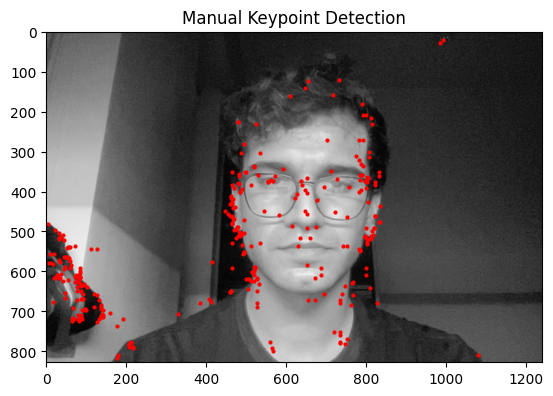

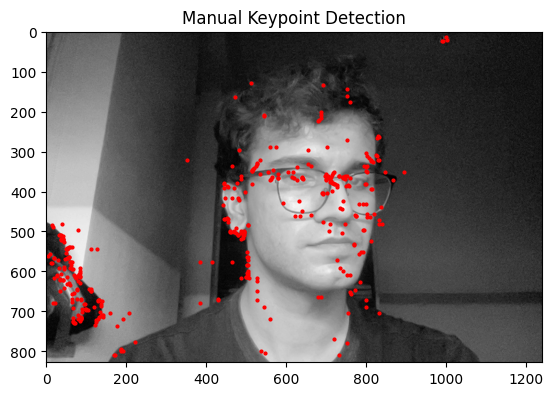

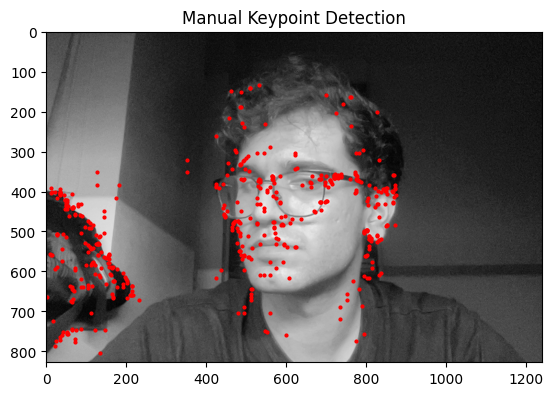

In [26]:
import cv2

img_1 = cv2.imread('3_images/selfie1.jpg')
img_2 = cv2.imread('3_images/selfie2.jpg')
img_3 = cv2.imread('3_images/selfie3.jpg')

gray_img1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
gray_img3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2GRAY)

sift_detector = SIFT_Keypoint_Detector(nfeatures=0, nLayersinOctave=3, contrastThreshold=0.13, edgeThreshold=10, sigma=1.6)

keypoints1 = sift_detector.detect_keypoints(gray_img1)
sift_detector.draw_keypoints(gray_img1, keypoints1)

keypoints2 = sift_detector.detect_keypoints(gray_img2)
sift_detector.draw_keypoints(gray_img2, keypoints2)

keypoints3 = sift_detector.detect_keypoints(gray_img3)
sift_detector.draw_keypoints(gray_img3, keypoints3)

### Results:

1. Keypoints from different angles are being detected at similar places.

2. The keypoint clusters are dense around eyes, nose, ears, my specs, mouth and eyebrows.